# Plots for Section 3 (Method)

In [ ]:
import os

import pandas as pd

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import random

import galcheat
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import yaml
from madness_deblender.dataset_generator import batched_CATSIMDataset
from madness_deblender.FlowVAEnet import FlowVAEnet
from madness_deblender.utils import get_data_dir_path, get_madness_deblender_config_path

%matplotlib inline

mpl.rcParams["savefig.dpi"] = 1200

tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
with open(get_madness_deblender_config_path()) as f:
    madness_deblender_config = yaml.safe_load(f)
btksims_config = madness_deblender_config["btksims"]
survey_name = madness_deblender_config["survey_name"]
survey = galcheat.get_survey(survey_name)

In [ ]:
survey.pixel_scale.value

0.2

In [ ]:
linear_norm_coeff = 10000
batch_size = 50

## Load trained models

In [ ]:
data_dir = get_data_dir_path()

tf.get_logger().setLevel("ERROR")
latent_dim = 16
num_nf_layers = 6
kl_weight = 2

model_path = os.path.join(data_dir, "LSST0.01")

flow_net = FlowVAEnet(latent_dim=latent_dim, num_nf_layers=num_nf_layers)

flow_net.load_flow_weights(weights_path=os.path.join(model_path, "flow/val_loss"))
flow_net.load_vae_weights(weights_path=os.path.join(model_path, "vae/val_loss"))

flow_net.vae_model.trainable = False
flow_net.flow_model.trainable = False

## Section 3.3: Normalizing Flows 

### Check latent modeling

In [ ]:
ds_isolated_train, ds_isolated_val = batched_CATSIMDataset(
    tf_dataset_dir=os.path.join(
        madness_deblender_config["TF_DATASET_PATH"][
            madness_deblender_config["survey_name"]
        ],
        "isolated_tfDataset",
    ),
    linear_norm_coeff=linear_norm_coeff,
    batch_size=batch_size,
    x_col_name="blended_gal_stamps",
    y_col_name="isolated_gal_stamps",
)
ds_isolated_val = ds_isolated_val.as_numpy_iterator()
ds_isolated_train = ds_isolated_train.as_numpy_iterator()

You use TensorFlow DType <dtype: 'float32'> in tfds.features This will soon be deprecated in favor of NumPy DTypes. In the meantime it was converted to float32.
Load dataset info from /sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0
Fields info.[module_name] from disk and from code do not match. Keeping the one from code.
Reusing dataset catsim_dataset (/sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0)
Constructing tf.data.Dataset catsim_dataset for split None, from /sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0


In [ ]:
latent_vars = []
for i in range(200):
    isolated_images_batch = next(ds_isolated_val)
    # images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))
    z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(
        flow_net.encoder(isolated_images_batch[0])
    )

    latent_vars.extend(list(z.sample().numpy()))
latent_vars = np.array(latent_vars)

In [ ]:
# reshape for plotting
latent_vars_list = []
for i in range(latent_dim):
    latent_vars_list.append(latent_vars[:, i])

In [ ]:
sampled_latent_vars = flow_net.td.sample(len(latent_vars_list[0]), seed=13).numpy()
sampled_latent_vars_list = []
for i in range(latent_dim):
    sampled_latent_vars_list.append(sampled_latent_vars[:, i])

In [ ]:
latent_value = []
latent_var_num = []
latent_type = []

df_sns = {}

for i in range(5):
    df_sns["Variable " + str(i + 1)] = np.concatenate(
        (latent_vars_list[i], sampled_latent_vars_list[i])
    )

df_sns["latent type"] = ["actual"] * len(latent_vars_list[i]) + ["NF modeled"] * len(
    sampled_latent_vars_list[i]
)
df_sns = pd.DataFrame(df_sns)

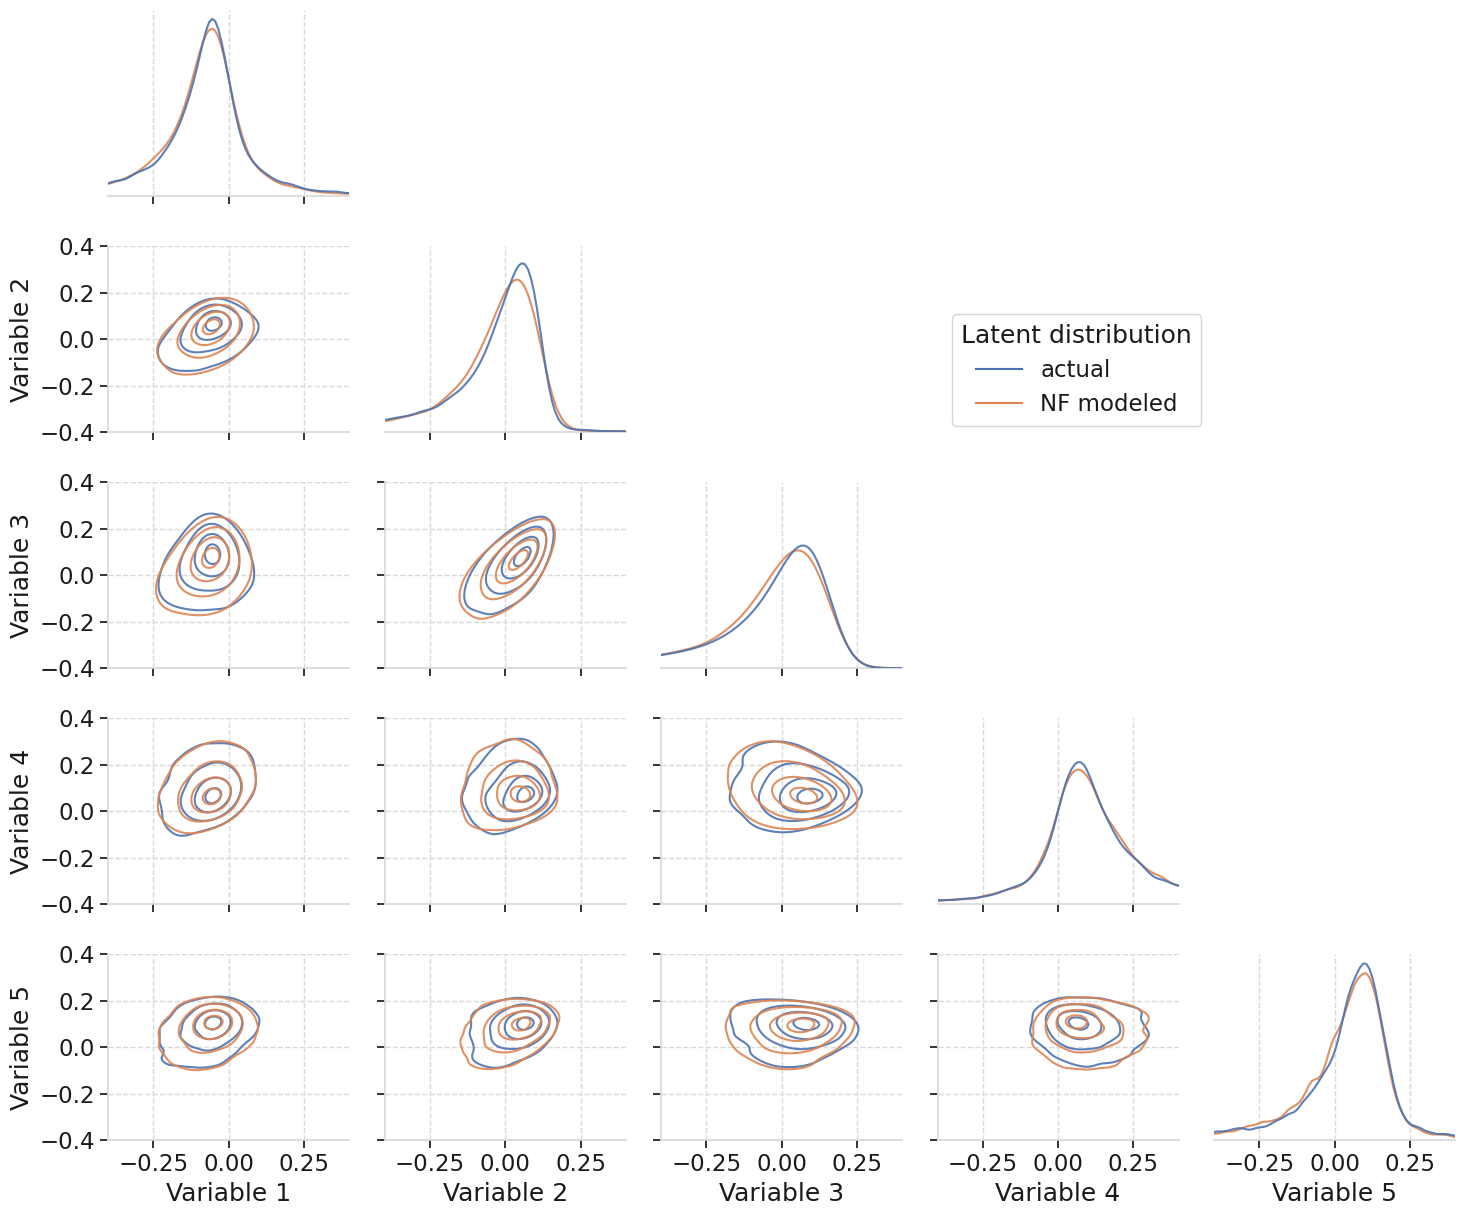

In [ ]:
sns.set_theme(
    font_scale=1.5,
    style={
        "style": "whitegrid",
        "xtick.bottom": True,
        "axes.grid": True,
        "xtick.top": False,
        "ytick.left": True,
        "ytick.right": False,
        "text.color": ".1",
        "xtick.color": ".1",
        "ytick.color": ".1",
        "axes.edgecolor": ".85",
        "axes.labelcolor": ".1",
    },
    rc={"grid.color": ".85", "grid.linestyle": "--"},
)
g = sns.PairGrid(df_sns, hue="latent type", corner=True)

g.map_lower(
    sns.kdeplot,
    clip=[-1, 1],
    levels=[0.4, 0.6, 0.8, 0.95],
    gridsize=200,
    common_norm=False,
    common_grid=False,
    bw_method="scott",
    bw_adjust=0.1,
    fill=False,
    alpha=0.9,
)
g.map_diag(
    sns.kdeplot,
    clip=[-1, 1],
    gridsize=200,
    common_norm=False,
    common_grid=True,
    bw_method="scott",
    bw_adjust=0.1,
    alpha=0.9,
)


for col in range(5):
    g.axes[col, col].set_xlim([-0.4, 0.4])
    g.axes[col, col].set_ylim([-0.4, 0.4])

g.add_legend(title="Latent distribution", loc=[0.65, 0.65], frameon=True)
plt.tight_layout()

plt.savefig(
    os.path.join("results", "latent_distribution_correlation.pdf"), bbox_inches="tight"
)

### Check simulations after NF

#### First sample form strandard normal

In [ ]:
zdist = tfd.Independent(
    tfd.Normal(loc=tf.zeros(latent_dim), scale=1), reinterpreted_batch_ndims=1
)
prior_simulation = flow_net.decoder(zdist.sample(10, seed=17)).numpy()

In [ ]:
np.shape(prior_simulation)

(10, 45, 45, 6)

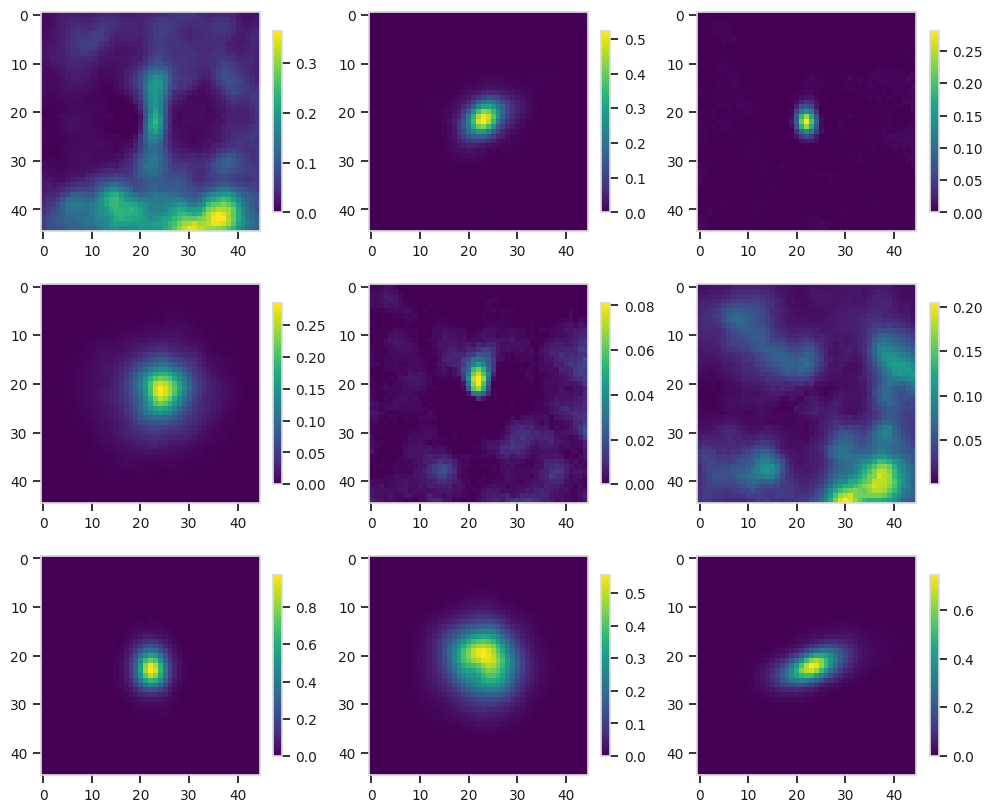

In [ ]:
sns.set_theme(
    font_scale=0.9,
    style={
        "style": "whitegrid",
        "xtick.bottom": True,
        "axes.grid": False,
        "xtick.top": False,
        "ytick.left": True,
        "ytick.right": False,
        "text.color": ".1",
        "xtick.color": ".1",
        "ytick.color": ".1",
        "axes.edgecolor": ".85",
        "axes.labelcolor": ".1",
    },
    rc={"grid.color": ".85", "grid.linestyle": "--"},
)

fig, axs = plt.subplots(3, 3, figsize=(12, 10))

for plot_row in range(3):
    for plot_col in range(3):
        im = axs[plot_row][plot_col].imshow(
            prior_simulation[plot_row * 3 + plot_col, :, :, 3]
        )
        cbar = fig.colorbar(im, ax=axs[plot_row][plot_col], shrink=0.8)
        # cbar.ax.tick_params(labelsize=12)
        # axs[plot_row][plot_col].tick_params(axis="both", which="major", labelsize=12)
        # axs[plot_row][plot_col].set_title("image" + str(plot_row*5+plot_col+1))

plt.savefig(os.path.join("results", "prior_simulations.pdf"), bbox_inches="tight")

#### Now try the Normalizing Flow

In [ ]:
simulation = flow_net.decoder(flow_net.td.sample(10, seed=11)).numpy()

In [ ]:
np.shape(simulation)

(10, 45, 45, 6)

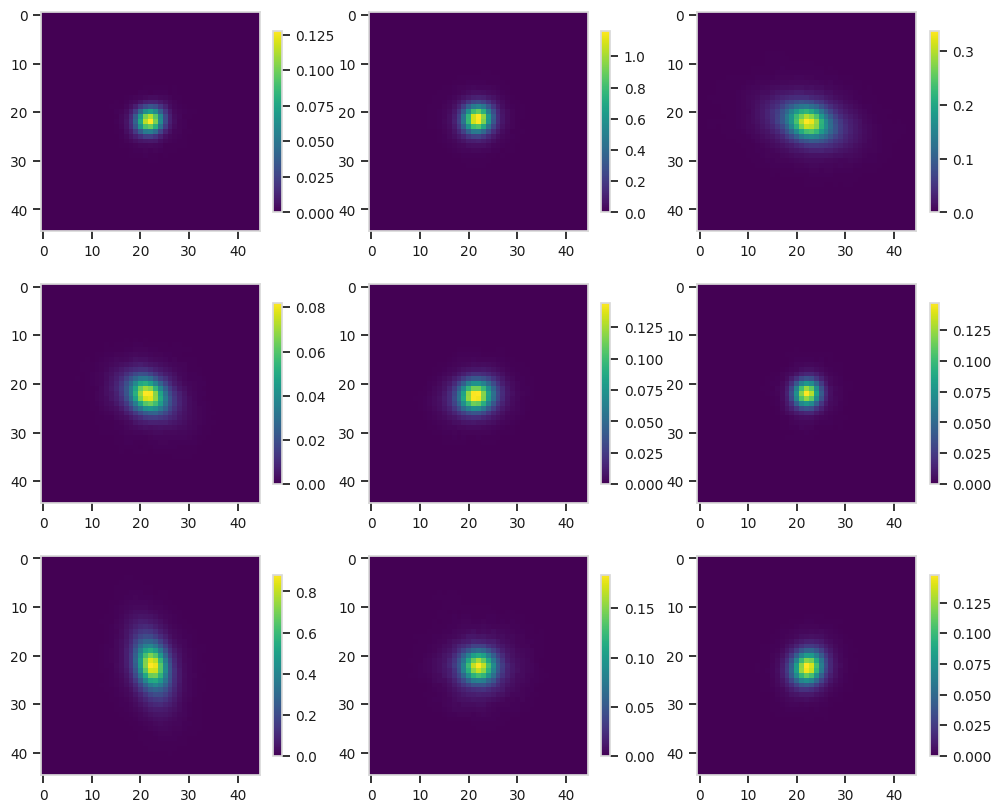

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

for plot_row in range(3):
    for plot_col in range(3):

        im = axs[plot_row][plot_col].imshow(
            simulation[plot_row * 3 + plot_col, :, :, 3]
        )
        cbar = fig.colorbar(im, ax=axs[plot_row][plot_col], shrink=0.8)
#         cbar.ax.tick_params(labelsize=12)
#         axs[plot_row][plot_col].tick_params(axis="both", which="major", labelsize=12)
#         # axs[plot_row][plot_col].set_title("image" + str(plot_row*5+plot_col+1))

plt.savefig("results/nf_simulations.pdf", bbox_inches="tight")

## Section 3.4: VAE-deblender

In [ ]:
blended_images_dir = os.path.join(
    btksims_config["TRAIN_DATA_SAVE_PATH"][survey_name], "blended_validation"
)

In [ ]:
flow_net.load_encoder_weights(
    weights_path=os.path.join(model_path, "deblender/val_loss")
)

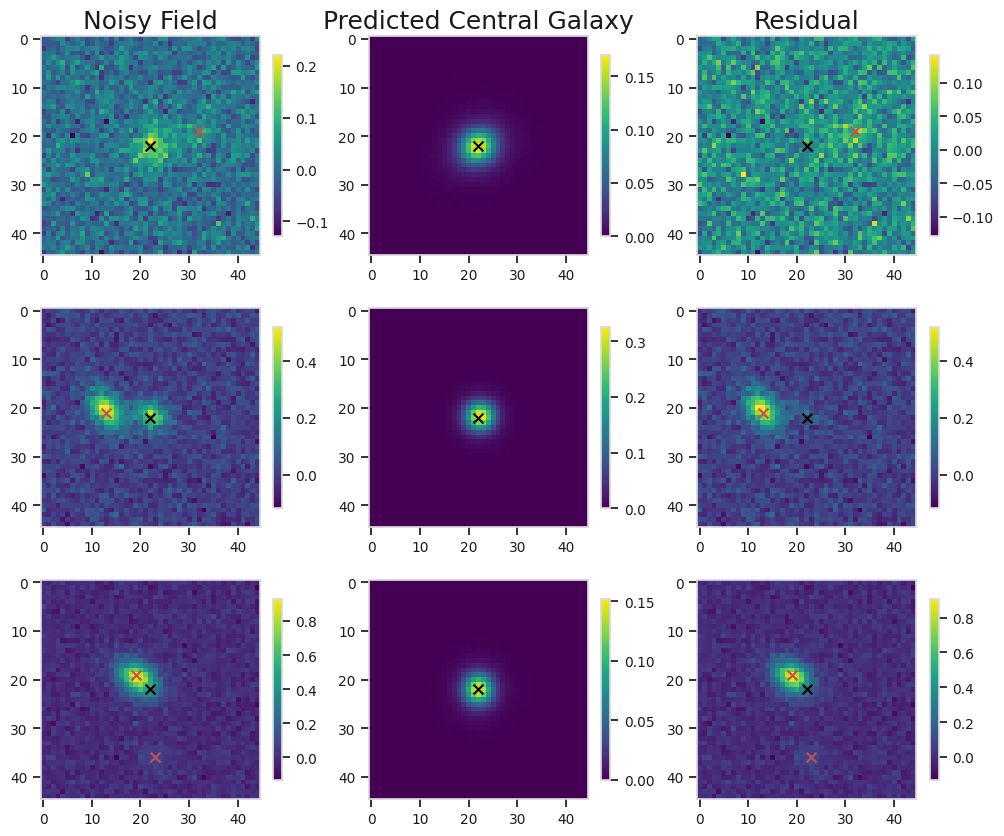

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

random.seed(17)

band = 2

for i in range(3):
    filename = random.choice(os.listdir(blended_images_dir))
    blended_images = np.load(
        os.path.join(blended_images_dir, filename), allow_pickle=True
    )

    model_vae_output_isolated = flow_net.vae_model(
        np.array(list(blended_images["blended_gal_stamps"])) / linear_norm_coeff
    )

    im = axs[i, 0].imshow(
        blended_images["blended_gal_stamps"][0][:, :, band] / linear_norm_coeff
    )
    cbar = fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    #     cbar.ax.tick_params(labelsize=13)

    im = axs[i, 1].imshow(model_vae_output_isolated[0][:, :, band])
    cbar = fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    #     cbar.ax.tick_params(labelsize=13)

    difference = (
        blended_images["blended_gal_stamps"][0][:, :, band] / linear_norm_coeff
        - model_vae_output_isolated[0][:, :, band]
    )
    im = axs[i, 2].imshow(difference)
    cbar = fig.colorbar(im, ax=axs[i, 2], shrink=0.8)
    #     cbar.ax.tick_params(labelsize=13)

    for num_gal in range(len(blended_images["gal_locations_x_peak"][0])):

        axs[i, 0].scatter(
            np.round(blended_images["gal_locations_x_peak"][0][num_gal]) + 22,
            np.round(blended_images["gal_locations_y_peak"][0][num_gal]) + 22,
            c="r",
            marker="x",
            s=50,
        )

        axs[i, 2].scatter(
            np.round(blended_images["gal_locations_x_peak"][0][num_gal]) + 22,
            np.round(blended_images["gal_locations_y_peak"][0][num_gal]) + 22,
            c="r",
            marker="x",
            s=50,
        )

    for col_num in range(3):
        axs[i, col_num].scatter(22, 22, c="black", marker="x", s=50)
#         axs[i, col_num].tick_params(axis="both", which="major", labelsize=13)


axs[0, 0].set_title("Noisy Field", fontsize=18)
axs[0, 1].set_title("Predicted Central Galaxy", fontsize=18)
axs[0, 2].set_title("Residual", fontsize=18)

plt.savefig(os.path.join("results", "VAEDeblender.pdf"), bbox_inches="tight")

In [ ]:
flow_net.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_2 (Dense)             (None, 512)               8704      
                                                                 
 p_re_lu_6 (PReLU)           (None, 512)               512       
                                                                 
 tf.cast (TFOpLambda)        (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4608)              2363904   
                                                                 
 p_re_lu_7 (PReLU)           (None, 4608)              4608      
                                                                 
 reshape (Reshape)           (None, 6, 6, 128)         0   

In [ ]:
flow_net.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45, 45, 6)]       0         
                                                                 
 conv2d (Conv2D)             (None, 23, 23, 32)        4832      
                                                                 
 p_re_lu (PReLU)             (None, 23, 23, 32)        16928     
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       102528    
                                                                 
 p_re_lu_1 (PReLU)           (None, 12, 12, 128)       18432     
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 256)         819456    
                                                                 
 p_re_lu_2 (PReLU)           (None, 6, 6, 256)         9216